In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler #нормализатор MinMax
from sklearn.preprocessing import StandardScaler #нормализатор Standard
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
import statsmodels.api as sm

import pickle

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,  BatchNormalization
from tensorflow.keras.layers import Normalization, LayerNormalization
from tensorflow.keras.optimizers import Adam

%matplotlib inline

In [2]:
raw_df = pd.read_csv('../datasets/ebw_data.csv', sep = ',') #загружаем исходный датасет в raw_df 
df = raw_df.copy() #копируем исходный датасет raw_df в df

In [3]:
results_comp = []

In [4]:
df.head() #смотрим первые 5 строк

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


In [5]:
df.tail() #смотрим последние 5 строк

,IW,IF,VW,FP,Depth,Width
67,44,146,9.0,60,1.20,1.72
68,45,146,9.0,60,1.36,1.76
69,45,146,9.0,60,1.28,1.76
70,45,146,9.0,60,1.28,1.76
71,45,146,9.0,60,1.32,1.76


In [6]:
df.shape #смотрим размерность датасета, имеет 72 строки и 6 столбцов

(72, 6)

In [7]:
df.info() #смотрим информацию о датасете: названия столбцов, количество строк, тип данных, а также ищем пропуски

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


In [8]:
df.isnull().sum() #альтернативный способ посмотреть нулевые значения в столбцах

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

In [9]:
df.describe() #смотрим описательную статистику

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


In [10]:
corr = df.corr() #смотрим корреляционную матрицу
corr

,IW,IF,VW,FP,Depth,Width
IW,1.000000,-0.861073,-0.043430,0.835530,-0.289568,0.434869
IF,-0.861073,1.000000,0.115093,-0.980562,0.376084,-0.510167
VW,-0.043430,0.115093,1.000000,-0.001060,-0.671437,-0.874257
FP,0.835530,-0.980562,-0.001060,1.000000,-0.510748,0.412962
Depth,-0.289568,0.376084,-0.671437,-0.510748,1.000000,0.425391
Width,0.434869,-0.510167,-0.874257,0.412962,0.425391,1.000000


<AxesSubplot:>

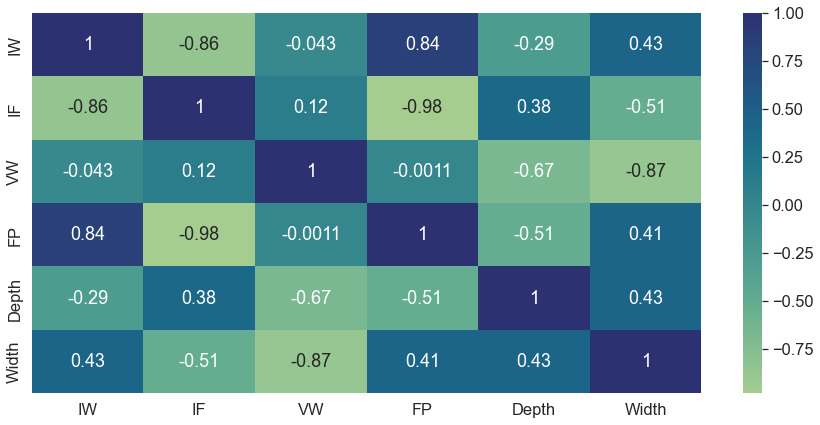

In [11]:
sns.set(font_scale=1.5) 
f, ax = plt.subplots(figsize=(15,7)) # выводим heatmap для корреляционной матрицы
sns.heatmap(corr, annot=True, ax=ax, cmap="crest")

# Визуализация исходного датасета

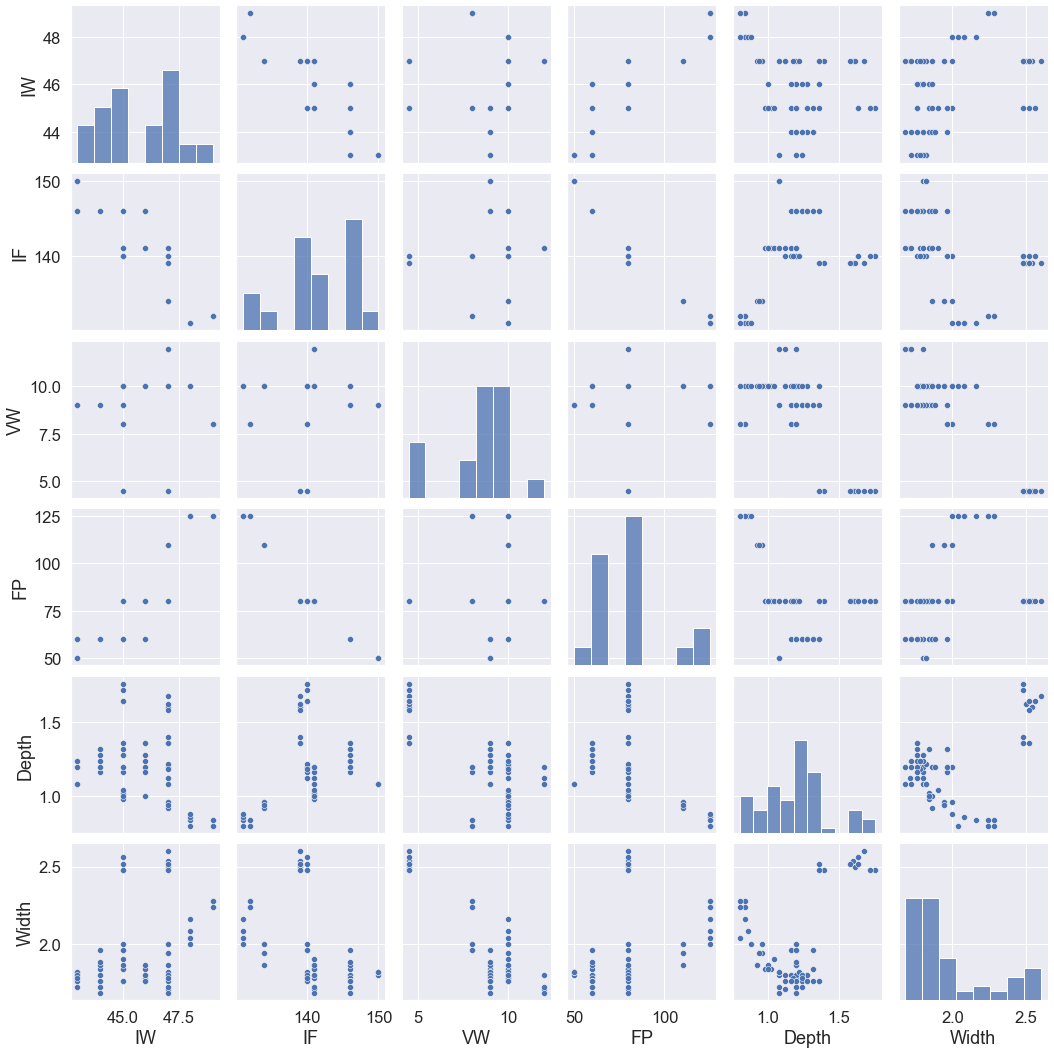

In [12]:
sns.pairplot(df)

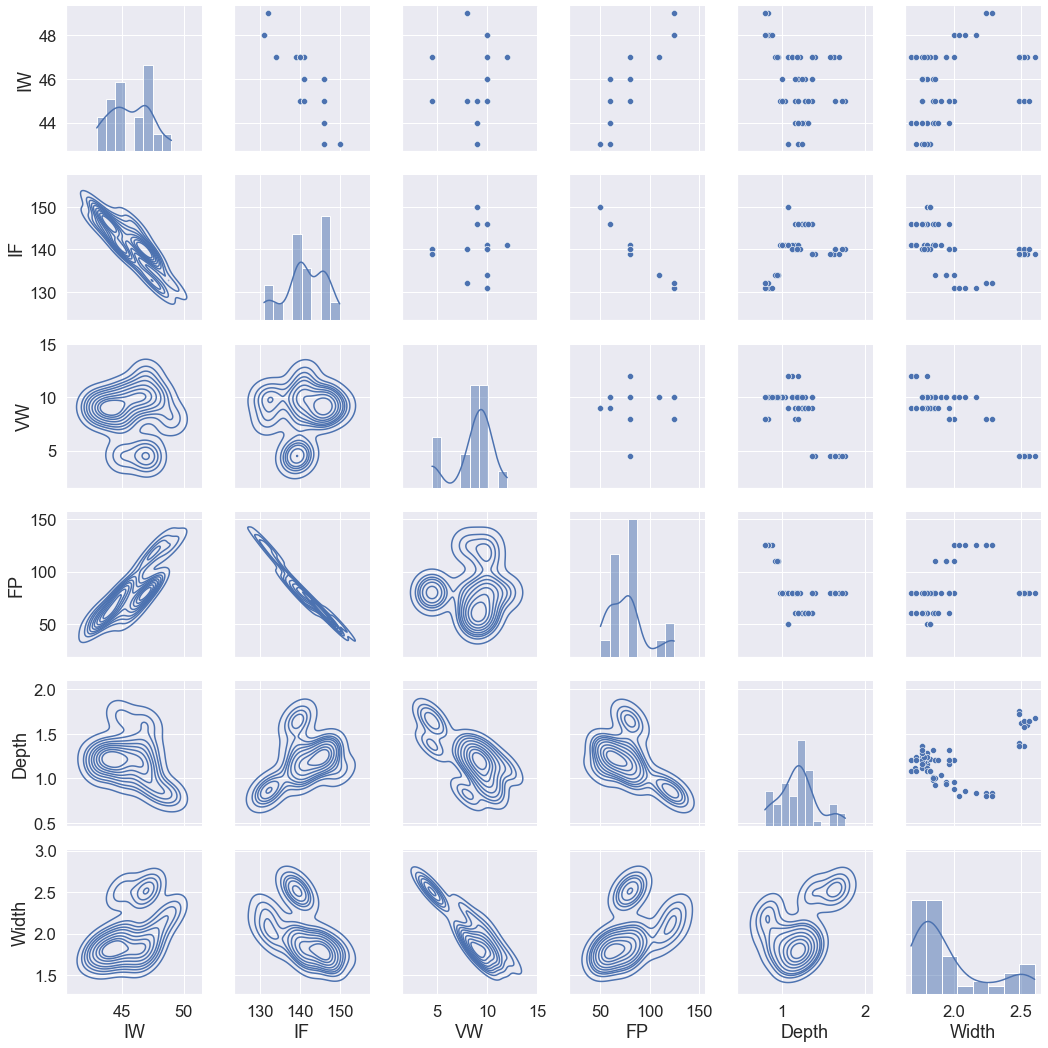

In [13]:
diagram = sns.PairGrid(df, diag_sharey=True)
diagram.map_lower(sns.kdeplot) # Ядерная оценка плотности
diagram.map_upper(sns.scatterplot) # Диаграмма рассеивания
diagram.map_diag(sns.histplot, kde=True) # Гистограмма

# Нормализация MinMaxScaler

In [14]:
minmax_scaler = MinMaxScaler()

In [15]:
dataset_norm = minmax_scaler.fit_transform(np.array(df[['IW', 'IF', 'VW', 'FP', 'Depth', 'Width']]))

In [16]:
dataset_norm[:3] #выводим первые 3 строки

array([[0.66666667, 0.42105263, 0.        , 0.4       , 0.83333333,
        0.93478261],
       [0.66666667, 0.42105263, 0.        , 0.4       , 0.85416667,
        0.89130435],
       [0.66666667, 0.42105263, 0.        , 0.4       , 0.91666667,
        1.        ]])

In [17]:
df[:3]

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60


In [18]:
df_norm = pd.DataFrame(data = dataset_norm, columns = ['IW', 'IF', 'VW', 'FP', 'Depth', 'Width'] )
df_norm.head()

,IW,IF,VW,FP,Depth,Width
0,0.666667,0.421053,0.0,0.4,0.833333,0.934783
1,0.666667,0.421053,0.0,0.4,0.854167,0.891304
2,0.666667,0.421053,0.0,0.4,0.916667,1.000000
3,0.666667,0.421053,0.0,0.4,0.812500,0.913043
4,0.333333,0.473684,0.0,0.4,1.000000,0.869565


In [19]:
df_norm.describe() #смотрим описательную статистику, все корректно отработало, т.к. все значения лежат в интервале [0, 1]

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,0.444444,0.543860,0.551852,0.377778,0.412037,0.315670
std,0.279727,0.270830,0.274810,0.286580,0.234460,0.303304
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166667,0.421053,0.466667,0.133333,0.291667,0.086957
50%,0.416667,0.526316,0.600000,0.400000,0.416667,0.173913
75%,0.666667,0.789474,0.733333,0.400000,0.510417,0.402174
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


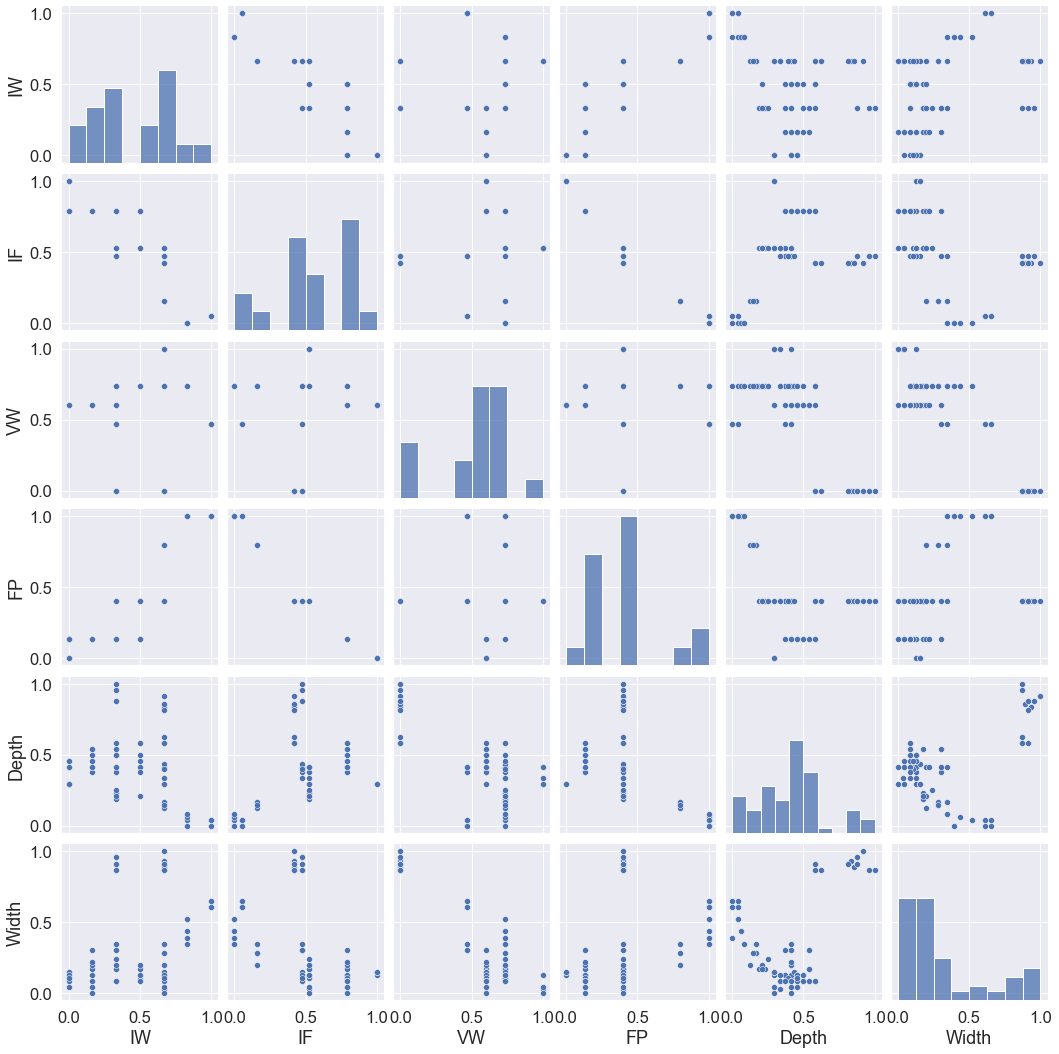

In [20]:
sns.pairplot(df_norm)

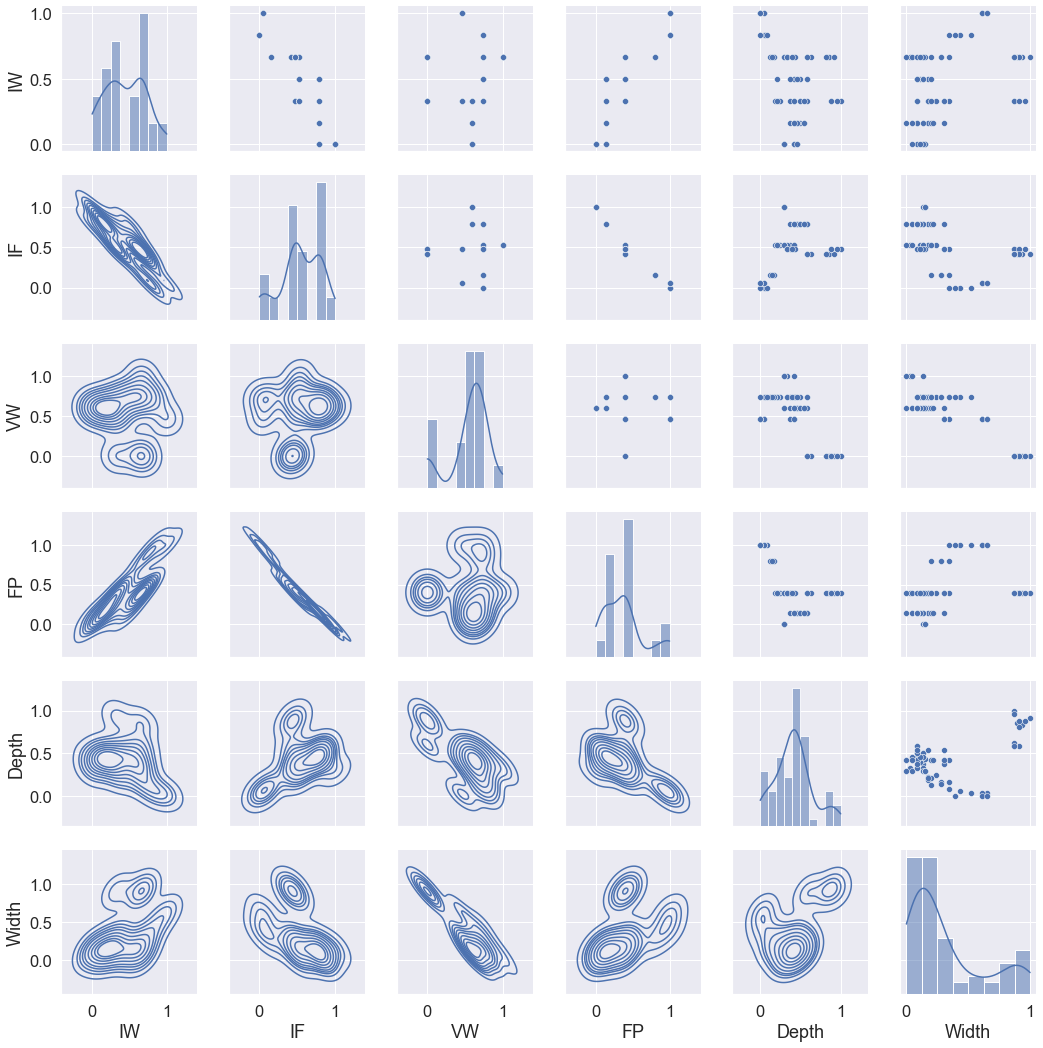

In [21]:
dg_norm = sns.PairGrid(df_norm, diag_sharey=False)
dg_norm.map_lower(sns.kdeplot)
dg_norm.map_upper(sns.scatterplot)
dg_norm.map_diag(sns.histplot, kde=True)

# Нормализация StandardScaler

In [22]:
std_scaler = StandardScaler()

In [23]:
dataset_std = std_scaler.fit_transform(np.array(df[['IW', 'IF', 'VW', 'FP', 'Depth', 'Width']]))

In [24]:
dataset_std[:3] #выводим первые 3 строки

array([[ 0.8       , -0.45662965, -2.02221044,  0.07808688,  1.80949024,
         2.05555078],
       [ 0.8       , -0.45662965, -2.02221044,  0.07808688,  1.89897053,
         1.91119608],
       [ 0.8       , -0.45662965, -2.02221044,  0.07808688,  2.16741139,
         2.27208283]])

In [25]:
df_std = pd.DataFrame(data = dataset_std, columns = ['IW', 'IF', 'VW', 'FP', 'Depth', 'Width'] )
df_std.head()

,IW,IF,VW,FP,Depth,Width
0,0.8,-0.456630,-2.02221,0.078087,1.809490,2.055551
1,0.8,-0.456630,-2.02221,0.078087,1.898971,1.911196
2,0.8,-0.456630,-2.02221,0.078087,2.167411,2.272083
3,0.8,-0.456630,-2.02221,0.078087,1.720010,1.983373
4,-0.4,-0.260931,-2.02221,0.078087,2.525333,1.839019


In [26]:
df_std.describe() #смотрим описательную статистику

,IW,IF,VW,FP,Depth,Width
count,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01
mean,1.437122e-15,-1.844204e-15,-6.784696e-17,3.361509e-16,2.667619e-16,-1.541976e-17
std,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00
min,-1.600000e+00,-2.022217e+00,-2.022210e+00,-1.327477e+00,-1.769721e+00,-1.048075e+00
25%,-1.000000e+00,-4.566297e-01,-3.121533e-01,-8.589557e-01,-5.169972e-01,-7.593659e-01
50%,-1.000000e-01,-6.523281e-02,1.764345e-01,7.808688e-02,1.988451e-02,-4.706565e-01
75%,8.000000e-01,9.132593e-01,6.650222e-01,7.808688e-02,4.225458e-01,2.872057e-01
max,2.000000e+00,1.696053e+00,1.642198e+00,2.186433e+00,2.525333e+00,2.272083e+00


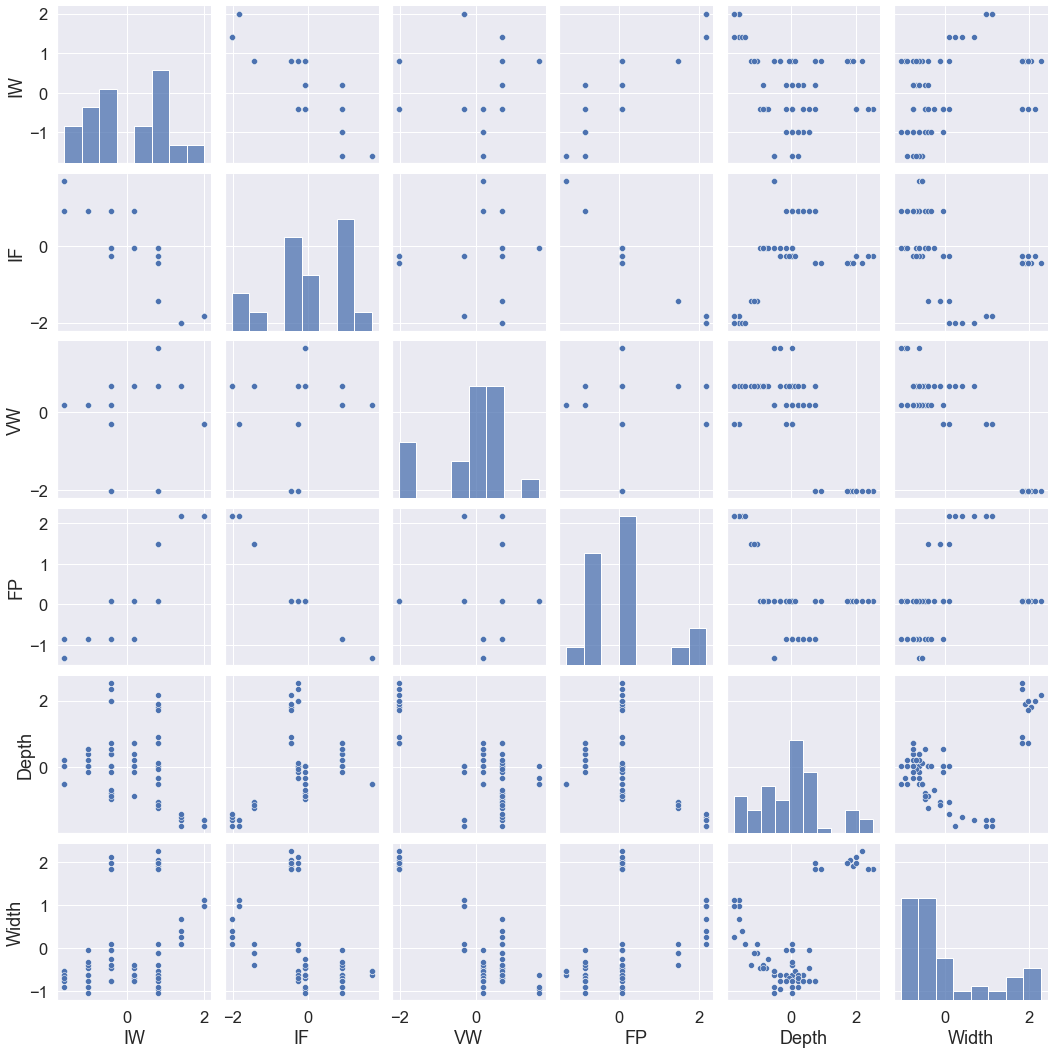

In [27]:
sns.pairplot(df_std)

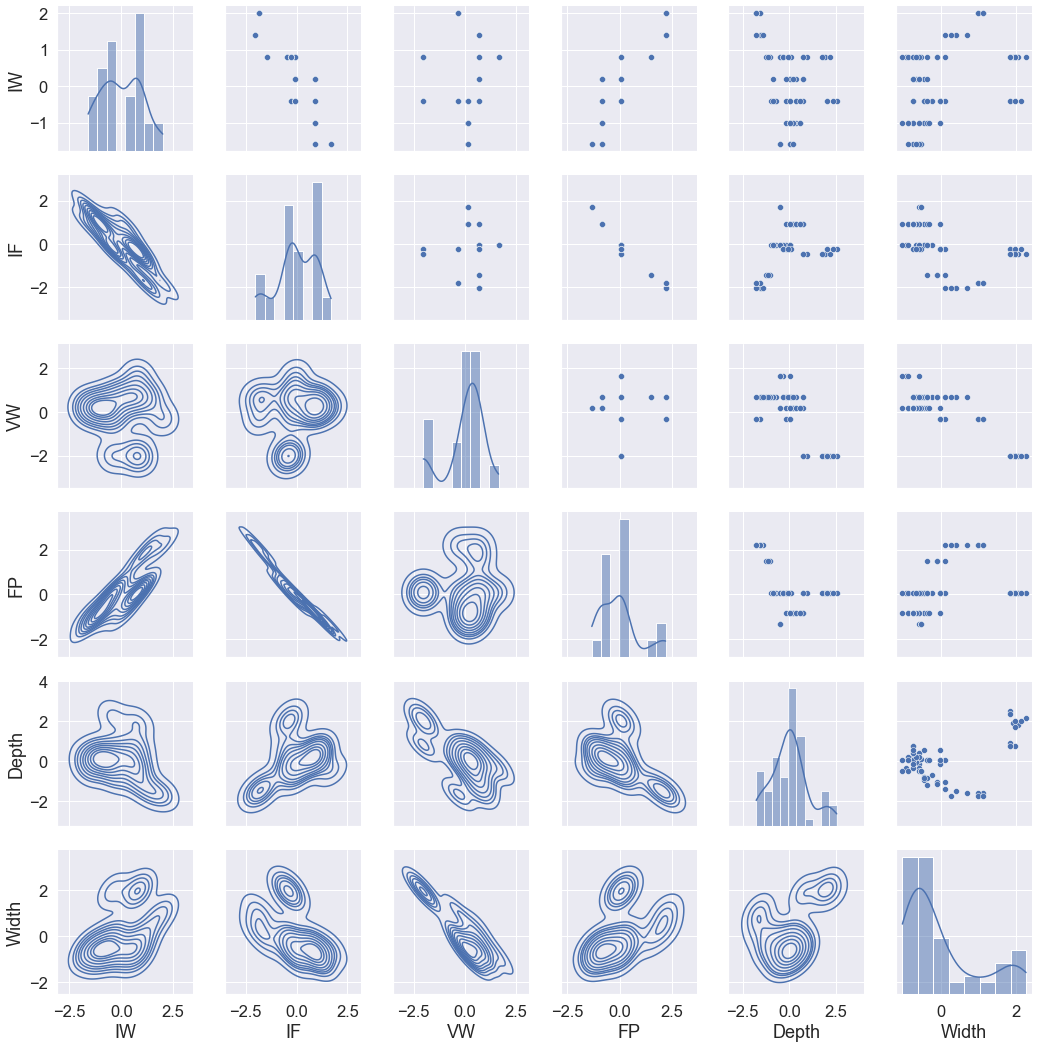

In [28]:
dg_std = sns.PairGrid(df_std, diag_sharey=False)
dg_std.map_lower(sns.kdeplot)
dg_std.map_upper(sns.scatterplot)
dg_std.map_diag(sns.histplot, kde=True)

# Поиск выбросов

Text(0, 0.5, 'Метод MinMaxScaler')

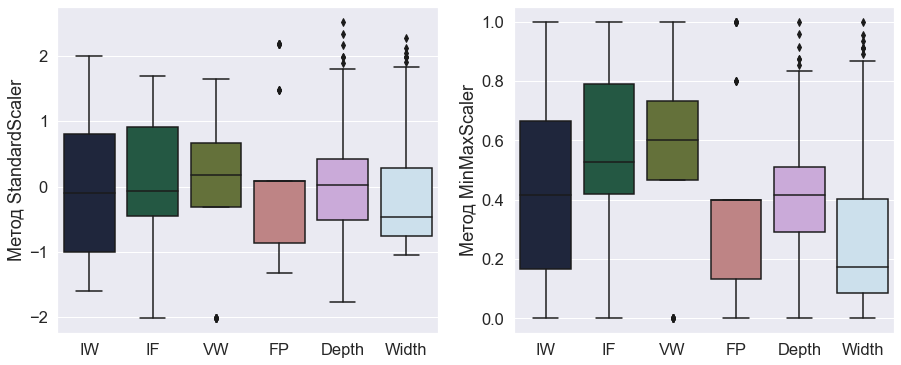

In [29]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
sns.boxplot(data=df_std, palette='cubehelix') # Рисуем "ящик с усами" для датасета, нормализованного с помощью StandardScaler 
plt.ylabel('Метод StandardScaler')

plt.subplot(122)
sns.boxplot(data=df_norm, palette='cubehelix') # Рисуем "ящик с усами" для датасета, нормализованного с помощью MinMaxScaler
plt.ylabel('Метод MinMaxScaler')

In [30]:
#df = df_std # Для дальнейшей работы выбираем датасет, нормализованный с помощью StandardScalerdf
#df

# Избавляемся от выбросов через Z-оценку

In [31]:
z = np.abs(stats.zscore(df))
df_cleanZ = df[(z<3).all(axis=1)] # убираем из датасета только те записи, для которых все Z-оценки лежат в интервале [-3, 3]
df_cleanZ.shape

(72, 6)

# Избавляемся от выбросов через межквартильный размах

In [32]:
Q1 = df[['VW', 'FP']].quantile(q=.25) # первый квартиль 
Q3 = df[[ 'VW', 'FP']].quantile(q=.75) # третий квартиль 
IQR = df[['VW', 'FP']].apply(stats.iqr) # межквартильный размах

In [33]:
df_clean = df[(df['VW'] < (Q1['VW']-1.5*IQR['VW'])) | (df['VW'] > (Q1['VW']+1.5*IQR['VW']))]
df_clean, df_clean.shape

(    IW   IF    VW  FP  Depth  Width
 0   47  139   4.5  80   1.60   2.54
 1   47  139   4.5  80   1.62   2.50
 2   47  139   4.5  80   1.68   2.60
 3   47  139   4.5  80   1.58   2.52
 4   45  140   4.5  80   1.76   2.48
 5   45  140   4.5  80   1.72   2.48
 6   45  140   4.5  80   1.64   2.52
 7   45  140   4.5  80   1.64   2.56
 20  47  141  12.0  80   1.12   1.71
 21  47  141  12.0  80   1.08   1.68
 22  47  141  12.0  80   1.20   1.80
 23  47  141  12.0  80   1.08   1.72
 28  47  139   4.5  80   1.36   2.52
 29  47  139   4.5  80   1.36   2.48
 30  47  139   4.5  80   1.40   2.48
 31  47  139   4.5  80   1.36   2.48,
 (16, 6))

In [34]:
df_clean = df[(df['FP'] < (Q1['FP']-1.5*IQR['FP'])) | (df['FP'] > (Q1['FP']+1.5*IQR['FP']))]
df_clean, df_clean.shape

(    IW   IF    VW   FP  Depth  Width
 24  47  134  10.0  110   0.96   2.00
 25  47  134  10.0  110   0.96   1.94
 26  47  134  10.0  110   0.92   1.86
 27  47  134  10.0  110   0.94   1.94
 32  48  131  10.0  125   0.84   2.16
 33  48  131  10.0  125   0.86   2.08
 34  48  131  10.0  125   0.88   2.00
 35  48  131  10.0  125   0.80   2.04
 36  49  132   8.0  125   0.84   2.28
 37  49  132   8.0  125   0.84   2.24
 38  49  132   8.0  125   0.80   2.24
 39  49  132   8.0  125   0.80   2.28,
 (12, 6))

# Разделяем выборку на регрессоры X и предикторы yd, yw

In [35]:
#df = df_norm # берем минмакс датасет для работы в ИНС
#df = df_std # берем стандартизированный датасет для работы в ИНС
df

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48
...,...,...,...,...,...,...
67,44,146,9.0,60,1.20,1.72
68,45,146,9.0,60,1.36,1.76
69,45,146,9.0,60,1.28,1.76
70,45,146,9.0,60,1.28,1.76


In [36]:
predict_depth = "Depth"
predict_width = "Width"

In [37]:
X = np.array(df.drop([predict_depth, predict_width], 1))

C:\Users\dwrki\AppData\Local\Temp\ipykernel_3804\381396112.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(df.drop([predict_depth, predict_width], 1))


In [38]:
yd = np.array(df[predict_depth])

In [39]:
yw = np.array(df[predict_width])

# 1 С помощью встроенных методов (без разделения на тестовую и валидацинную выборки)
## 1.1 Регрессия с помощью модуля statsmodels.api.OLS

In [40]:
X = sm.add_constant(X)
model = sm.OLS(yd, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     71.08
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           2.19e-23
Time:                        12:52:12   Log-Likelihood:                 65.366
No. Observations:                  72   AIC:                            -120.7
Df Residuals:                      67   BIC:                            -109.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7900      2.836      4.510      0.0

In [41]:
X = sm.add_constant(X)
model = sm.OLS(yw, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     279.1
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           5.48e-41
Time:                        12:52:12   Log-Likelihood:                 93.608
No. Observations:                  72   AIC:                            -177.2
Df Residuals:                      67   BIC:                            -165.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9748      1.916      0.509      0.6

## 1.2 Регрессия с помощью sklearn linear_model.LinearRegression()

In [42]:
X = np.array(df.drop([predict_depth, predict_width], 1))

C:\Users\dwrki\AppData\Local\Temp\ipykernel_3804\381396112.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(df.drop([predict_depth, predict_width], 1))


In [43]:
regressionD = linear_model.LinearRegression()

In [44]:
regressionD.fit(X, yd)

LinearRegression()

In [45]:
regressionD.intercept_, regressionD.coef_

(12.790012957720926,
 array([ 0.02116132, -0.07252623, -0.05199885, -0.02376048]))

In [46]:
regressionD.score(X, yd) # R^2 для Depth

0.8092951739829064

In [47]:
regressionW = linear_model.LinearRegression()

In [48]:
regressionW.fit(X, yw)

LinearRegression()

In [49]:
regressionW.intercept_, regressionW.coef_

(0.9747816679496122,
 array([ 0.0300595 ,  0.00235607, -0.11793195,  0.0039412 ]))

In [50]:
regressionW.score(X, yw) # R^2 для Width

0.9433759236085345

# 2 С разделением на тестовые и валидационные выборки

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, yd, test_size = 0.3, random_state = 42) # для Depth

In [52]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(50, 4) (22, 4) (50,) (22,)


## 2.1 Width

# 2.1.1 sklearn linear_model.LinearRegression() 

In [53]:
regressionDepth = linear_model.LinearRegression()
regressionDepth.fit(X_train, y_train)

LinearRegression()

In [54]:
regressionDepth.intercept_, regressionDepth.coef_

(12.893518794065105,
 array([ 0.02590605, -0.0743182 , -0.05283151, -0.02460041]))

In [55]:
regressionDepth.score(X_train, y_train)

0.8643345750804321

In [56]:
y_predictD = regressionDepth.predict(X_test)
y_predictD, y_test

(array([1.4489695 , 1.20551453, 1.10998403, 1.5750998 , 1.5750998 ,
        1.23142058, 1.2640592 , 0.79795983, 1.08407798, 1.1542458 ,
        1.23040117, 1.5750998 , 1.2640592 , 1.23040117, 1.4489695 ,
        1.03022705, 1.23142058, 1.23142058, 0.79795983, 0.85521071,
        1.23142058, 1.10998403]),
 array([1.76, 1.2 , 1.2 , 1.6 , 1.36, 1.24, 1.16, 0.88, 0.98, 1.08, 1.24,
        1.36, 1.2 , 1.36, 1.72, 1.2 , 1.2 , 1.32, 0.86, 0.8 , 1.2 , 1.2 ]))

In [57]:
print(" MAE =", mean_absolute_error(y_test, y_predictD), "\n", 
    "MSE =", mean_squared_error(y_test, y_predictD), "\n", 
     "R_squared =", r2_score(y_test, y_predictD))

 MAE = 0.10170050568076022 
 MSE = 0.01727723476287999 
 R_squared = 0.6976708789395963


In [58]:
res1 = ['Depth', 
         'LinearRegression', 
         mean_absolute_error(y_test, y_predictD), 
         mean_squared_error(y_test, y_predictD), 
         r2_score(y_test, y_predictD)]

In [59]:
results_comp.append(res1)

## 2.1.2 Нейросеть

In [60]:
X_train

array([[ 48. , 131. ,  10. , 125. ],
       [ 46. , 146. ,  10. ,  60. ],
       [ 45. , 146. ,   9. ,  60. ],
       [ 45. , 140. ,   4.5,  80. ],
       [ 43. , 150. ,   9. ,  50. ],
       [ 47. , 140. ,  10. ,  80. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 46. , 146. ,  10. ,  60. ],
       [ 45. , 146. ,   9. ,  60. ],
       [ 46. , 141. ,  10. ,  80. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 47. , 134. ,  10. , 110. ],
       [ 47. , 140. ,  10. ,  80. ],
       [ 45. , 141. ,  10. ,  80. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 46. , 141. ,  10. ,  80. ],
       [ 49. , 132. ,   8. , 125. ],
       [ 45. , 140. ,   8. ,  80. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 45. , 140. ,   4.5,  80. ],
       [ 49. , 132. ,   8. , 125. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 43. , 150. ,   9. ,  50. ],
       [ 45. , 146. ,   9. ,  60. ],
       [ 45. , 141. ,  10. ,  80. ],
       [ 47. , 134. ,  10. , 110. ],
 

Epoch 1/1000
2/2 - 1s - loss: 1.1529 - mse: 1.1529 - mae: 0.9752 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 639ms/epoch - 319ms/step
Epoch 2/1000
2/2 - 0s - loss: 1.1116 - mse: 1.1116 - mae: 0.9536 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 20ms/epoch - 10ms/step
Epoch 3/1000
2/2 - 0s - loss: 1.0870 - mse: 1.0870 - mae: 0.9466 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 18ms/epoch - 9ms/step
Epoch 4/1000
2/2 - 0s - loss: 1.0409 - mse: 1.0409 - mae: 0.9192 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 18ms/epoch - 9ms/step
Epoch 5/1000
2/2 - 0s - loss: 1.0631 - mse: 1.0631 - mae: 0.9290 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 18ms/epoch - 9ms/step
Epoch 6/1000
2/2 - 0s - loss: 1.0590 - mse: 1.0590 - mae: 0.9169 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 18ms/epoch - 9ms/step
Epoch 7/1000
2/2 - 0s - loss: 0.9928 - mse: 0.9928 - mae: 0.8887 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 19ms/epoch

Epoch 58/1000
2/2 - 0s - loss: 0.7566 - mse: 0.7566 - mae: 0.7206 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 18ms/epoch - 9ms/step
Epoch 59/1000
2/2 - 0s - loss: 0.7643 - mse: 0.7643 - mae: 0.7104 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 18ms/epoch - 9ms/step
Epoch 60/1000
2/2 - 0s - loss: 0.7761 - mse: 0.7761 - mae: 0.7409 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 18ms/epoch - 9ms/step
Epoch 61/1000
2/2 - 0s - loss: 0.7565 - mse: 0.7565 - mae: 0.6836 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 19ms/epoch - 10ms/step
Epoch 62/1000
2/2 - 0s - loss: 0.7712 - mse: 0.7712 - mae: 0.7271 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 17ms/epoch - 9ms/step
Epoch 63/1000
2/2 - 0s - loss: 0.7617 - mse: 0.7617 - mae: 0.7008 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 18ms/epoch - 9ms/step
Epoch 64/1000
2/2 - 0s - loss: 0.7470 - mse: 0.7470 - mae: 0.6946 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 17ms/e

Epoch 115/1000
2/2 - 0s - loss: 0.3293 - mse: 0.3293 - mae: 0.4164 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 18ms/epoch - 9ms/step
Epoch 116/1000
2/2 - 0s - loss: 0.3394 - mse: 0.3394 - mae: 0.4141 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 17ms/epoch - 8ms/step
Epoch 117/1000
2/2 - 0s - loss: 0.3182 - mse: 0.3182 - mae: 0.3930 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 20ms/epoch - 10ms/step
Epoch 118/1000
2/2 - 0s - loss: 0.3043 - mse: 0.3043 - mae: 0.4030 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 18ms/epoch - 9ms/step
Epoch 119/1000
2/2 - 0s - loss: 0.3037 - mse: 0.3037 - mae: 0.3977 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 18ms/epoch - 9ms/step
Epoch 120/1000
2/2 - 0s - loss: 0.3024 - mse: 0.3024 - mae: 0.4062 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 - 19ms/epoch - 9ms/step
Epoch 121/1000
2/2 - 0s - loss: 0.3225 - mse: 0.3225 - mae: 0.4258 - val_loss: 1.5768 - val_mse: 1.5768 - val_mae: 1.2327 -

2/2 - 0s - loss: 0.0318 - mse: 0.0318 - mae: 0.1368 - val_loss: 0.0656 - val_mse: 0.0656 - val_mae: 0.2046 - 19ms/epoch - 9ms/step
Epoch 172/1000
2/2 - 0s - loss: 0.0153 - mse: 0.0153 - mae: 0.1016 - val_loss: 0.0622 - val_mse: 0.0622 - val_mae: 0.1978 - 19ms/epoch - 10ms/step
Epoch 173/1000
2/2 - 0s - loss: 0.0262 - mse: 0.0262 - mae: 0.1220 - val_loss: 0.0587 - val_mse: 0.0587 - val_mae: 0.1906 - 19ms/epoch - 9ms/step
Epoch 174/1000
2/2 - 0s - loss: 0.0136 - mse: 0.0136 - mae: 0.0983 - val_loss: 0.0562 - val_mse: 0.0562 - val_mae: 0.1852 - 18ms/epoch - 9ms/step
Epoch 175/1000
2/2 - 0s - loss: 0.0171 - mse: 0.0171 - mae: 0.1083 - val_loss: 0.0539 - val_mse: 0.0539 - val_mae: 0.1806 - 18ms/epoch - 9ms/step
Epoch 176/1000
2/2 - 0s - loss: 0.0166 - mse: 0.0166 - mae: 0.0976 - val_loss: 0.0515 - val_mse: 0.0515 - val_mae: 0.1762 - 18ms/epoch - 9ms/step
Epoch 177/1000
2/2 - 0s - loss: 0.0182 - mse: 0.0182 - mae: 0.1007 - val_loss: 0.0495 - val_mse: 0.0495 - val_mae: 0.1725 - 18ms/epoch - 9

Epoch 228/1000
2/2 - 0s - loss: 0.0106 - mse: 0.0106 - mae: 0.0790 - val_loss: 0.0213 - val_mse: 0.0213 - val_mae: 0.1096 - 19ms/epoch - 9ms/step
Epoch 229/1000
2/2 - 0s - loss: 0.0169 - mse: 0.0169 - mae: 0.1017 - val_loss: 0.0212 - val_mse: 0.0212 - val_mae: 0.1093 - 18ms/epoch - 9ms/step
Epoch 230/1000
2/2 - 0s - loss: 0.0129 - mse: 0.0129 - mae: 0.0882 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.1089 - 18ms/epoch - 9ms/step
Epoch 231/1000
2/2 - 0s - loss: 0.0129 - mse: 0.0129 - mae: 0.0866 - val_loss: 0.0210 - val_mse: 0.0210 - val_mae: 0.1084 - 19ms/epoch - 10ms/step
Epoch 232/1000
2/2 - 0s - loss: 0.0125 - mse: 0.0125 - mae: 0.0857 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1076 - 18ms/epoch - 9ms/step
Epoch 233/1000
2/2 - 0s - loss: 0.0972 - mse: 0.0972 - mae: 0.2224 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.1062 - 18ms/epoch - 9ms/step
Epoch 234/1000
2/2 - 0s - loss: 0.0445 - mse: 0.0445 - mae: 0.1633 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.1059 -

2/2 - 0s - loss: 0.0120 - mse: 0.0120 - mae: 0.0782 - val_loss: 0.0188 - val_mse: 0.0188 - val_mae: 0.1023 - 18ms/epoch - 9ms/step
Epoch 285/1000
2/2 - 0s - loss: 0.0194 - mse: 0.0194 - mae: 0.1065 - val_loss: 0.0188 - val_mse: 0.0188 - val_mae: 0.1022 - 19ms/epoch - 10ms/step
Epoch 286/1000
2/2 - 0s - loss: 0.0282 - mse: 0.0282 - mae: 0.1059 - val_loss: 0.0188 - val_mse: 0.0188 - val_mae: 0.1019 - 20ms/epoch - 10ms/step
Epoch 287/1000
2/2 - 0s - loss: 0.0194 - mse: 0.0194 - mae: 0.1042 - val_loss: 0.0190 - val_mse: 0.0190 - val_mae: 0.1018 - 19ms/epoch - 9ms/step
Epoch 288/1000
2/2 - 0s - loss: 0.0371 - mse: 0.0371 - mae: 0.1301 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.1019 - 20ms/epoch - 10ms/step
Epoch 289/1000
2/2 - 0s - loss: 0.0172 - mse: 0.0172 - mae: 0.0956 - val_loss: 0.0192 - val_mse: 0.0192 - val_mae: 0.1022 - 18ms/epoch - 9ms/step
Epoch 290/1000
2/2 - 0s - loss: 0.0124 - mse: 0.0124 - mae: 0.0785 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.1022 - 19ms/epoch -

2/2 - 0s - loss: 0.0144 - mse: 0.0144 - mae: 0.0836 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1019 - 18ms/epoch - 9ms/step
Epoch 341/1000
2/2 - 0s - loss: 0.0546 - mse: 0.0546 - mae: 0.1792 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.1018 - 18ms/epoch - 9ms/step
Epoch 342/1000
2/2 - 0s - loss: 0.0199 - mse: 0.0199 - mae: 0.1038 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.1020 - 18ms/epoch - 9ms/step
Epoch 343/1000
2/2 - 0s - loss: 0.0218 - mse: 0.0218 - mae: 0.1160 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.1023 - 19ms/epoch - 9ms/step
Epoch 344/1000
2/2 - 0s - loss: 0.0230 - mse: 0.0230 - mae: 0.1149 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.1025 - 19ms/epoch - 9ms/step
Epoch 345/1000
2/2 - 0s - loss: 0.0157 - mse: 0.0157 - mae: 0.0891 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1027 - 19ms/epoch - 10ms/step
Epoch 346/1000
2/2 - 0s - loss: 0.0234 - mse: 0.0234 - mae: 0.1143 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1027 - 18ms/epoch - 9

Epoch 397/1000
2/2 - 0s - loss: 0.0075 - mse: 0.0075 - mae: 0.0715 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1025 - 19ms/epoch - 10ms/step
Epoch 398/1000
2/2 - 0s - loss: 0.0077 - mse: 0.0077 - mae: 0.0708 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1024 - 19ms/epoch - 9ms/step
Epoch 399/1000
2/2 - 0s - loss: 0.0112 - mse: 0.0112 - mae: 0.0820 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1025 - 19ms/epoch - 9ms/step
Epoch 400/1000
2/2 - 0s - loss: 0.0098 - mse: 0.0098 - mae: 0.0772 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1024 - 18ms/epoch - 9ms/step
Epoch 401/1000
2/2 - 0s - loss: 0.0085 - mse: 0.0085 - mae: 0.0746 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1024 - 18ms/epoch - 9ms/step
Epoch 402/1000
2/2 - 0s - loss: 0.0202 - mse: 0.0202 - mae: 0.1091 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1026 - 18ms/epoch - 9ms/step
Epoch 403/1000
2/2 - 0s - loss: 0.0218 - mse: 0.0218 - mae: 0.1114 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1025 -

Epoch 453/1000
2/2 - 0s - loss: 0.0106 - mse: 0.0106 - mae: 0.0757 - val_loss: 0.0179 - val_mse: 0.0179 - val_mae: 0.1026 - 18ms/epoch - 9ms/step
Epoch 454/1000
2/2 - 0s - loss: 0.0181 - mse: 0.0181 - mae: 0.0991 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1025 - 18ms/epoch - 9ms/step
Epoch 455/1000
2/2 - 0s - loss: 0.0216 - mse: 0.0216 - mae: 0.0910 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1023 - 18ms/epoch - 9ms/step
Epoch 456/1000
2/2 - 0s - loss: 0.0088 - mse: 0.0088 - mae: 0.0708 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1022 - 18ms/epoch - 9ms/step
Epoch 457/1000
2/2 - 0s - loss: 0.0110 - mse: 0.0110 - mae: 0.0818 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1021 - 18ms/epoch - 9ms/step
Epoch 458/1000
2/2 - 0s - loss: 0.0096 - mse: 0.0096 - mae: 0.0773 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1017 - 19ms/epoch - 10ms/step
Epoch 459/1000
2/2 - 0s - loss: 0.0753 - mse: 0.0753 - mae: 0.1921 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1014 -

2/2 - 0s - loss: 0.0134 - mse: 0.0134 - mae: 0.0820 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1041 - 18ms/epoch - 9ms/step
Epoch 510/1000
2/2 - 0s - loss: 0.0097 - mse: 0.0097 - mae: 0.0809 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1043 - 18ms/epoch - 9ms/step
Epoch 511/1000
2/2 - 0s - loss: 0.0134 - mse: 0.0134 - mae: 0.0951 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1043 - 19ms/epoch - 9ms/step
Epoch 512/1000
2/2 - 0s - loss: 0.0170 - mse: 0.0170 - mae: 0.1025 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1039 - 19ms/epoch - 9ms/step
Epoch 513/1000
2/2 - 0s - loss: 0.0134 - mse: 0.0134 - mae: 0.0795 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1042 - 18ms/epoch - 9ms/step
Epoch 514/1000
2/2 - 0s - loss: 0.0068 - mse: 0.0068 - mae: 0.0624 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1043 - 19ms/epoch - 10ms/step
Epoch 515/1000
2/2 - 0s - loss: 0.0087 - mse: 0.0087 - mae: 0.0743 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.1039 - 18ms/epoch - 9

Epoch 566/1000
2/2 - 0s - loss: 0.0218 - mse: 0.0218 - mae: 0.1115 - val_loss: 0.0179 - val_mse: 0.0179 - val_mae: 0.1036 - 18ms/epoch - 9ms/step
Epoch 567/1000
2/2 - 0s - loss: 0.0183 - mse: 0.0183 - mae: 0.1064 - val_loss: 0.0179 - val_mse: 0.0179 - val_mae: 0.1034 - 18ms/epoch - 9ms/step
Epoch 568/1000
2/2 - 0s - loss: 0.0210 - mse: 0.0210 - mae: 0.1210 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1034 - 18ms/epoch - 9ms/step
Epoch 569/1000
2/2 - 0s - loss: 0.0136 - mse: 0.0136 - mae: 0.0882 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.1033 - 18ms/epoch - 9ms/step
Epoch 570/1000
2/2 - 0s - loss: 0.0137 - mse: 0.0137 - mae: 0.0967 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1031 - 19ms/epoch - 9ms/step
Epoch 571/1000
2/2 - 0s - loss: 0.0106 - mse: 0.0106 - mae: 0.0823 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.1031 - 18ms/epoch - 9ms/step
Epoch 572/1000
2/2 - 0s - loss: 0.0135 - mse: 0.0135 - mae: 0.0941 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1029 - 

Epoch 622/1000
2/2 - 0s - loss: 0.0077 - mse: 0.0077 - mae: 0.0713 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1017 - 19ms/epoch - 9ms/step
Epoch 623/1000
2/2 - 0s - loss: 0.0109 - mse: 0.0109 - mae: 0.0844 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1015 - 17ms/epoch - 8ms/step
Epoch 624/1000
2/2 - 0s - loss: 0.0077 - mse: 0.0077 - mae: 0.0719 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1014 - 18ms/epoch - 9ms/step
Epoch 625/1000
2/2 - 0s - loss: 0.0070 - mse: 0.0070 - mae: 0.0695 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1012 - 19ms/epoch - 10ms/step
Epoch 626/1000
2/2 - 0s - loss: 0.0219 - mse: 0.0219 - mae: 0.1288 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1009 - 19ms/epoch - 10ms/step
Epoch 627/1000
2/2 - 0s - loss: 0.0108 - mse: 0.0108 - mae: 0.0911 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.1010 - 19ms/epoch - 9ms/step
Epoch 628/1000
2/2 - 0s - loss: 0.0087 - mse: 0.0087 - mae: 0.0743 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.1010 

2/2 - 0s - loss: 0.0093 - mse: 0.0093 - mae: 0.0788 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1012 - 17ms/epoch - 9ms/step
Epoch 679/1000
2/2 - 0s - loss: 0.0079 - mse: 0.0079 - mae: 0.0641 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1011 - 17ms/epoch - 9ms/step
Epoch 680/1000
2/2 - 0s - loss: 0.0172 - mse: 0.0172 - mae: 0.0973 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1011 - 17ms/epoch - 9ms/step
Epoch 681/1000
2/2 - 0s - loss: 0.0099 - mse: 0.0099 - mae: 0.0728 - val_loss: 0.0174 - val_mse: 0.0174 - val_mae: 0.1010 - 17ms/epoch - 9ms/step
Epoch 682/1000
2/2 - 0s - loss: 0.0088 - mse: 0.0088 - mae: 0.0752 - val_loss: 0.0174 - val_mse: 0.0174 - val_mae: 0.1008 - 17ms/epoch - 8ms/step
Epoch 683/1000
2/2 - 0s - loss: 0.0303 - mse: 0.0303 - mae: 0.1438 - val_loss: 0.0174 - val_mse: 0.0174 - val_mae: 0.1006 - 17ms/epoch - 8ms/step
Epoch 684/1000
2/2 - 0s - loss: 0.0102 - mse: 0.0102 - mae: 0.0852 - val_loss: 0.0174 - val_mse: 0.0174 - val_mae: 0.1008 - 17ms/epoch - 8m

Epoch 735/1000
2/2 - 0s - loss: 0.0189 - mse: 0.0189 - mae: 0.1007 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1010 - 17ms/epoch - 9ms/step
Epoch 736/1000
2/2 - 0s - loss: 0.0072 - mse: 0.0072 - mae: 0.0675 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1011 - 17ms/epoch - 8ms/step
Epoch 737/1000
2/2 - 0s - loss: 0.0120 - mse: 0.0120 - mae: 0.0810 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.1010 - 17ms/epoch - 9ms/step
Epoch 738/1000
2/2 - 0s - loss: 0.0080 - mse: 0.0080 - mae: 0.0736 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.1010 - 16ms/epoch - 8ms/step
Epoch 739/1000
2/2 - 0s - loss: 0.0140 - mse: 0.0140 - mae: 0.0908 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.1011 - 16ms/epoch - 8ms/step
Epoch 740/1000
2/2 - 0s - loss: 0.0071 - mse: 0.0071 - mae: 0.0664 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1012 - 16ms/epoch - 8ms/step
Epoch 741/1000
2/2 - 0s - loss: 0.0234 - mse: 0.0234 - mae: 0.1139 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1011 - 

Epoch 792/1000
2/2 - 0s - loss: 0.0170 - mse: 0.0170 - mae: 0.1055 - val_loss: 0.0179 - val_mse: 0.0179 - val_mae: 0.1008 - 17ms/epoch - 8ms/step
Epoch 793/1000
2/2 - 0s - loss: 0.0128 - mse: 0.0128 - mae: 0.0764 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1011 - 17ms/epoch - 9ms/step
Epoch 794/1000
2/2 - 0s - loss: 0.0148 - mse: 0.0148 - mae: 0.1002 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1017 - 17ms/epoch - 9ms/step
Epoch 795/1000
2/2 - 0s - loss: 0.0131 - mse: 0.0131 - mae: 0.0939 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1020 - 17ms/epoch - 8ms/step
Epoch 796/1000
2/2 - 0s - loss: 0.0082 - mse: 0.0082 - mae: 0.0776 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1019 - 17ms/epoch - 8ms/step
Epoch 797/1000
2/2 - 0s - loss: 0.0099 - mse: 0.0099 - mae: 0.0810 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1021 - 17ms/epoch - 9ms/step
Epoch 798/1000
2/2 - 0s - loss: 0.0072 - mse: 0.0072 - mae: 0.0719 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1021 - 

Epoch 849/1000
2/2 - 0s - loss: 0.0087 - mse: 0.0087 - mae: 0.0744 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1016 - 16ms/epoch - 8ms/step
Epoch 850/1000
2/2 - 0s - loss: 0.0148 - mse: 0.0148 - mae: 0.0963 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1018 - 17ms/epoch - 8ms/step
Epoch 851/1000
2/2 - 0s - loss: 0.0093 - mse: 0.0093 - mae: 0.0764 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1015 - 16ms/epoch - 8ms/step
Epoch 852/1000
2/2 - 0s - loss: 0.0168 - mse: 0.0168 - mae: 0.1024 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1014 - 16ms/epoch - 8ms/step
Epoch 853/1000
2/2 - 0s - loss: 0.0113 - mse: 0.0113 - mae: 0.0844 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1011 - 17ms/epoch - 9ms/step
Epoch 854/1000
2/2 - 0s - loss: 0.0088 - mse: 0.0088 - mae: 0.0690 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1007 - 17ms/epoch - 9ms/step
Epoch 855/1000
2/2 - 0s - loss: 0.0077 - mse: 0.0077 - mae: 0.0683 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1005 - 

Epoch 906/1000
2/2 - 0s - loss: 0.0099 - mse: 0.0099 - mae: 0.0707 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1008 - 16ms/epoch - 8ms/step
Epoch 907/1000
2/2 - 0s - loss: 0.0085 - mse: 0.0085 - mae: 0.0691 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1007 - 16ms/epoch - 8ms/step
Epoch 908/1000
2/2 - 0s - loss: 0.0060 - mse: 0.0060 - mae: 0.0619 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1005 - 16ms/epoch - 8ms/step
Epoch 909/1000
2/2 - 0s - loss: 0.0119 - mse: 0.0119 - mae: 0.0887 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1004 - 31ms/epoch - 16ms/step
Epoch 910/1000
2/2 - 0s - loss: 0.0084 - mse: 0.0084 - mae: 0.0657 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1005 - 25ms/epoch - 13ms/step
Epoch 911/1000
2/2 - 0s - loss: 0.0110 - mse: 0.0110 - mae: 0.0873 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1006 - 20ms/epoch - 10ms/step
Epoch 912/1000
2/2 - 0s - loss: 0.0075 - mse: 0.0075 - mae: 0.0698 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.1006

2/2 - 0s - loss: 0.0088 - mse: 0.0088 - mae: 0.0704 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1025 - 24ms/epoch - 12ms/step
Epoch 963/1000
2/2 - 0s - loss: 0.0080 - mse: 0.0080 - mae: 0.0727 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1026 - 19ms/epoch - 9ms/step
Epoch 964/1000
2/2 - 0s - loss: 0.0166 - mse: 0.0166 - mae: 0.1051 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1027 - 19ms/epoch - 9ms/step
Epoch 965/1000
2/2 - 0s - loss: 0.0057 - mse: 0.0057 - mae: 0.0590 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1027 - 19ms/epoch - 10ms/step
Epoch 966/1000
2/2 - 0s - loss: 0.0072 - mse: 0.0072 - mae: 0.0676 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1025 - 20ms/epoch - 10ms/step
Epoch 967/1000
2/2 - 0s - loss: 0.0085 - mse: 0.0085 - mae: 0.0790 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1024 - 19ms/epoch - 10ms/step
Epoch 968/1000
2/2 - 0s - loss: 0.0095 - mse: 0.0095 - mae: 0.0827 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1022 - 20ms/epoch 

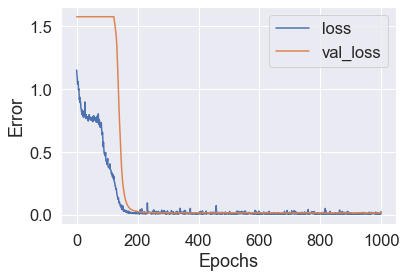

In [61]:
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(X_train.shape[1], input_dim = X_train.shape[1], activation='linear'))
model.add(BatchNormalization())
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer="adam", metrics=['mse', 'mae'])
history = model.fit(X_train, y_train,
                    epochs=1000,
                    verbose=2,
                    validation_data=(X_test, y_test))

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.show()

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 4)                16        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
 batch_normalization_1 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 57
Trainable params: 41
Non-trainable params: 16
_________________________________________________________________


In [63]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 14ms/step - loss: 0.0175 - mse: 0.0175 - mae: 0.1021


[0.017508981749415398, 0.017508981749415398, 0.10205769538879395]

In [64]:
y_preds = model.predict(X_test)

1/1 [==============================] - 0s 79ms/step


In [65]:
print(y_test)

[1.76 1.2  1.2  1.6  1.36 1.24 1.16 0.88 0.98 1.08 1.24 1.36 1.2  1.36
 1.72 1.2  1.2  1.32 0.86 0.8  1.2  1.2 ]


In [66]:
print(y_preds)

[[1.4663316 ]
 [1.194526  ]
 [1.1053174 ]
 [1.5831383 ]
 [1.5831383 ]
 [1.2137341 ]
 [1.2742568 ]
 [0.83884823]
 [1.086109  ]
 [1.1229184 ]
 [1.1972724 ]
 [1.5831383 ]
 [1.2742568 ]
 [1.1972724 ]
 [1.4663316 ]
 [1.0147686 ]
 [1.2137341 ]
 [1.2137341 ]
 [0.83884823]
 [0.8894236 ]
 [1.2137341 ]
 [1.1053174 ]]


In [67]:
X_test

array([[ 45. , 140. ,   4.5,  80. ],
       [ 43. , 146. ,   9. ,  60. ],
       [ 46. , 141. ,  10. ,  80. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 45. , 140. ,   8. ,  80. ],
       [ 48. , 131. ,  10. , 125. ],
       [ 45. , 141. ,  10. ,  80. ],
       [ 43. , 150. ,   9. ,  50. ],
       [ 46. , 146. ,  10. ,  60. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 45. , 140. ,   8. ,  80. ],
       [ 46. , 146. ,  10. ,  60. ],
       [ 45. , 140. ,   4.5,  80. ],
       [ 47. , 141. ,  12. ,  80. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 48. , 131. ,  10. , 125. ],
       [ 49. , 132. ,   8. , 125. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 46. , 141. ,  10. ,  80. ]])

In [68]:
print(" MAE =", mean_absolute_error(y_test, y_preds), "\n", 
    "MSE =", mean_squared_error(y_test, y_preds), "\n", 
     "R_squared =", r2_score(y_test,y_preds))

 MAE = 0.10205769278786397 
 MSE = 0.017508979024680838 
 R_squared = 0.6936156559862351


In [69]:
res3 = ['Depth', 
         'Neural', 
         mean_absolute_error(y_test, y_preds), 
         mean_squared_error(y_test, y_preds), 
         r2_score(y_test, y_preds)]
results_comp.append(res3)

In [70]:
model.save('../models/model_Depth.h5')

In [71]:
loaded_depth_model= load_model('../models/model_Depth.h5')

In [72]:
loaded_depth_model.predict(X_test)

1/1 [==============================] - 0s 46ms/step


array([[1.4663316 ],
       [1.194526  ],
       [1.1053174 ],
       [1.5831383 ],
       [1.5831383 ],
       [1.2137341 ],
       [1.2742568 ],
       [0.83884823],
       [1.086109  ],
       [1.1229184 ],
       [1.1972724 ],
       [1.5831383 ],
       [1.2742568 ],
       [1.1972724 ],
       [1.4663316 ],
       [1.0147686 ],
       [1.2137341 ],
       [1.2137341 ],
       [0.83884823],
       [0.8894236 ],
       [1.2137341 ],
       [1.1053174 ]], dtype=float32)

# 2.1.3 Решающий лес

In [73]:
tree = DecisionTreeRegressor()

In [74]:
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [75]:
y_pred_tree = tree.predict(X_test)

In [76]:
print(" MAE =", mean_absolute_error(y_test, y_pred_tree), "\n", 
    "MSE =", mean_squared_error(y_test, y_pred_tree), "\n", 
     "R_squared =", r2_score(y_test, y_pred_tree))

 MAE = 0.06672727272727272 
 MSE = 0.00686054545454545 
 R_squared = 0.879949383930121


In [77]:
res5 = ['Depth', 
         'Decision Tree', 
         mean_absolute_error(y_test, y_pred_tree), 
         mean_squared_error(y_test, y_pred_tree), 
         r2_score(y_test, y_pred_tree)]
results_comp.append(res5)

# 2.1.4 Случайный лес

In [78]:
model = RandomForestRegressor(n_estimators = 13, random_state=30)
model.fit(X_train, y_train)
y_pred_RF = model.predict(X_test)

In [79]:
print(" MAE =", mean_absolute_error(y_test, y_pred_RF), "\n", 
    "MSE =", mean_squared_error(y_test, y_pred_RF), "\n", 
     "R_squared =", r2_score(y_test,y_pred_RF))

 MAE = 0.07011796536796537 
 MSE = 0.007539722020807411 
 R_squared = 0.8680646780069277


In [80]:
res7 = ['Depth', 
         'Random Forest', 
         mean_absolute_error(y_test, y_pred_RF), 
         mean_squared_error(y_test, y_pred_RF), 
         r2_score(y_test, y_pred_RF)]
results_comp.append(res7)

# 3.1 WIDTH

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, yw, test_size = 0.3, random_state = 42) # для Width

In [82]:
X_test, type(X_test)

(array([[ 45. , 140. ,   4.5,  80. ],
        [ 43. , 146. ,   9. ,  60. ],
        [ 46. , 141. ,  10. ,  80. ],
        [ 47. , 139. ,   4.5,  80. ],
        [ 47. , 139. ,   4.5,  80. ],
        [ 44. , 146. ,   9. ,  60. ],
        [ 45. , 140. ,   8. ,  80. ],
        [ 48. , 131. ,  10. , 125. ],
        [ 45. , 141. ,  10. ,  80. ],
        [ 43. , 150. ,   9. ,  50. ],
        [ 46. , 146. ,  10. ,  60. ],
        [ 47. , 139. ,   4.5,  80. ],
        [ 45. , 140. ,   8. ,  80. ],
        [ 46. , 146. ,  10. ,  60. ],
        [ 45. , 140. ,   4.5,  80. ],
        [ 47. , 141. ,  12. ,  80. ],
        [ 44. , 146. ,   9. ,  60. ],
        [ 44. , 146. ,   9. ,  60. ],
        [ 48. , 131. ,  10. , 125. ],
        [ 49. , 132. ,   8. , 125. ],
        [ 44. , 146. ,   9. ,  60. ],
        [ 46. , 141. ,  10. ,  80. ]]),
 numpy.ndarray)

# 3.1.1 sklearn linear_model.LinearRegression()

In [83]:
regressionWidth = linear_model.LinearRegression()
regressionWidth.fit(X_train, y_train)

LinearRegression()

In [84]:
regressionWidth.intercept_, regressionWidth.coef_

(2.036588892297869,
 array([ 0.0192642 , -0.00151928, -0.11853297,  0.00372826]))

In [85]:
regressionWidth.score(X_train, y_train)

0.9341681373318841

In [86]:
y_predictW = regressionWidth.predict(X_test)
y_predictW, y_test

(array([2.45564144, 1.8000337 , 1.82145503, 2.49568913, 2.49568913,
        1.81929791, 2.04077604, 2.04294811, 1.80219082, 1.75667394,
        1.73929334, 2.49568913, 2.04077604, 1.73929334, 2.45564144,
        1.60365329, 1.81929791, 1.81929791, 2.04294811, 2.29775898,
        1.81929791, 1.82145503]),
 array([2.48, 1.72, 1.86, 2.54, 2.52, 1.8 , 1.96, 2.  , 1.84, 1.82, 1.76,
        2.48, 1.96, 1.76, 2.48, 1.8 , 1.76, 1.84, 2.08, 2.28, 1.76, 1.78]))

In [87]:
print(" MAE =", mean_absolute_error(y_test, y_predictW), "\n", 
    "MSE =", mean_squared_error(y_test, y_predictW), "\n", 
     "R_squared =", r2_score(y_test, y_predictW))

 MAE = 0.0477210830797381 
 MSE = 0.0037664538942062706 
 R_squared = 0.9558783912404679


In [88]:
res2 = ['Width', 
         'LinearRegression', 
         mean_absolute_error(y_test, y_predictW), 
         mean_squared_error(y_test, y_predictW), 
         r2_score(y_test, y_predictW)]

In [89]:
results_comp.append(res2)

# 3.1.2 Нейросеть

Epoch 1/1000
2/2 [==============================] - 1s 143ms/step - loss: 2.5086 - mse: 2.5086 - mae: 1.4386 - val_loss: 2007.1251 - val_mse: 2007.1251 - val_mae: 44.0680
Epoch 2/1000
2/2 [==============================] - 0s 17ms/step - loss: 2.5213 - mse: 2.5213 - mae: 1.4421 - val_loss: 2126.1055 - val_mse: 2126.1055 - val_mae: 45.7201
Epoch 3/1000
2/2 [==============================] - 0s 17ms/step - loss: 2.5355 - mse: 2.5355 - mae: 1.4637 - val_loss: 2045.4688 - val_mse: 2045.4688 - val_mae: 44.9381
Epoch 4/1000
2/2 [==============================] - 0s 17ms/step - loss: 2.4695 - mse: 2.4695 - mae: 1.4334 - val_loss: 1936.2313 - val_mse: 1936.2313 - val_mae: 43.7736
Epoch 5/1000
2/2 [==============================] - 0s 17ms/step - loss: 2.4182 - mse: 2.4182 - mae: 1.4173 - val_loss: 1819.8601 - val_mse: 1819.8601 - val_mae: 42.4684
Epoch 6/1000
2/2 [==============================] - 0s 17ms/step - loss: 2.3664 - mse: 2.3664 - mae: 1.3937 - val_loss: 1724.8105 - val_mse: 1724.810

2/2 [==============================] - 0s 15ms/step - loss: 1.9808 - mse: 1.9808 - mae: 1.2170 - val_loss: 271.8956 - val_mse: 271.8956 - val_mae: 16.3596
Epoch 50/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.9125 - mse: 1.9125 - mae: 1.1804 - val_loss: 259.0103 - val_mse: 259.0103 - val_mae: 15.9617
Epoch 51/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.8344 - mse: 1.8344 - mae: 1.1379 - val_loss: 247.0473 - val_mse: 247.0473 - val_mae: 15.5829
Epoch 52/1000
2/2 [==============================] - 0s 15ms/step - loss: 1.9355 - mse: 1.9355 - mae: 1.1906 - val_loss: 235.1973 - val_mse: 235.1973 - val_mae: 15.1985
Epoch 53/1000
2/2 [==============================] - 0s 17ms/step - loss: 2.0621 - mse: 2.0621 - mae: 1.2437 - val_loss: 224.3816 - val_mse: 224.3816 - val_mae: 14.8390
Epoch 54/1000
2/2 [==============================] - 0s 15ms/step - loss: 1.7663 - mse: 1.7663 - mae: 1.1079 - val_loss: 213.3154 - val_mse: 213.3154 - val_mae: 14.4628


2/2 [==============================] - 0s 18ms/step - loss: 1.5536 - mse: 1.5536 - mae: 1.0249 - val_loss: 18.2084 - val_mse: 18.2084 - val_mae: 3.9526
Epoch 99/1000
2/2 [==============================] - 0s 17ms/step - loss: 1.5180 - mse: 1.5180 - mae: 1.0032 - val_loss: 17.1625 - val_mse: 17.1625 - val_mae: 3.8393
Epoch 100/1000
2/2 [==============================] - 0s 17ms/step - loss: 1.7224 - mse: 1.7224 - mae: 1.0838 - val_loss: 16.1632 - val_mse: 16.1632 - val_mae: 3.7273
Epoch 101/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.5453 - mse: 1.5453 - mae: 1.0055 - val_loss: 15.2473 - val_mse: 15.2473 - val_mae: 3.6210
Epoch 102/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.6819 - mse: 1.6819 - mae: 1.1137 - val_loss: 14.4065 - val_mse: 14.4065 - val_mae: 3.5201
Epoch 103/1000
2/2 [==============================] - 0s 17ms/step - loss: 1.6663 - mse: 1.6663 - mae: 1.0455 - val_loss: 13.5556 - val_mse: 13.5556 - val_mae: 3.4143
Epoch 104/1000

2/2 [==============================] - 0s 16ms/step - loss: 1.2599 - mse: 1.2599 - mae: 0.8735 - val_loss: 1.3841 - val_mse: 1.3841 - val_mae: 0.9415
Epoch 148/1000
2/2 [==============================] - 0s 17ms/step - loss: 1.2682 - mse: 1.2682 - mae: 0.8639 - val_loss: 1.3351 - val_mse: 1.3351 - val_mae: 0.9226
Epoch 149/1000
2/2 [==============================] - 0s 17ms/step - loss: 1.2248 - mse: 1.2248 - mae: 0.8576 - val_loss: 1.2929 - val_mse: 1.2929 - val_mae: 0.9077
Epoch 150/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.2885 - mse: 1.2885 - mae: 0.8840 - val_loss: 1.2581 - val_mse: 1.2581 - val_mae: 0.8946
Epoch 151/1000
2/2 [==============================] - 0s 17ms/step - loss: 1.3022 - mse: 1.3022 - mae: 0.8696 - val_loss: 1.2241 - val_mse: 1.2241 - val_mae: 0.8813
Epoch 152/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.2752 - mse: 1.2752 - mae: 0.8701 - val_loss: 1.1916 - val_mse: 1.1916 - val_mae: 0.8680
Epoch 153/1000
2/2 [=====

Epoch 197/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.8316 - mse: 0.8316 - mae: 0.6480 - val_loss: 0.7121 - val_mse: 0.7121 - val_mae: 0.6104
Epoch 198/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.8031 - mse: 0.8031 - mae: 0.6177 - val_loss: 0.7000 - val_mse: 0.7000 - val_mae: 0.6111
Epoch 199/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.7372 - mse: 0.7372 - mae: 0.6229 - val_loss: 0.6873 - val_mse: 0.6873 - val_mae: 0.6100
Epoch 200/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.6876 - mse: 0.6876 - mae: 0.5973 - val_loss: 0.6754 - val_mse: 0.6754 - val_mae: 0.6091
Epoch 201/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.7246 - mse: 0.7246 - mae: 0.6046 - val_loss: 0.6562 - val_mse: 0.6562 - val_mae: 0.6063
Epoch 202/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.6491 - mse: 0.6491 - mae: 0.5810 - val_loss: 0.6176 - val_mse: 0.6176 - val_mae: 0.5977
Epoch 203/

Epoch 247/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0381 - mse: 0.0381 - mae: 0.1541 - val_loss: 0.0807 - val_mse: 0.0807 - val_mae: 0.2226
Epoch 248/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0433 - mse: 0.0433 - mae: 0.1697 - val_loss: 0.0783 - val_mse: 0.0783 - val_mae: 0.2175
Epoch 249/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0350 - mse: 0.0350 - mae: 0.1500 - val_loss: 0.0759 - val_mse: 0.0759 - val_mae: 0.2123
Epoch 250/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0345 - mse: 0.0345 - mae: 0.1504 - val_loss: 0.0739 - val_mse: 0.0739 - val_mae: 0.2074
Epoch 251/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0326 - mse: 0.0326 - mae: 0.1398 - val_loss: 0.0718 - val_mse: 0.0718 - val_mae: 0.2024
Epoch 252/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0290 - mse: 0.0290 - mae: 0.1355 - val_loss: 0.0700 - val_mse: 0.0700 - val_mae: 0.1979
Epoch 253/

Epoch 297/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0970 - val_loss: 0.0329 - val_mse: 0.0329 - val_mae: 0.1259
Epoch 298/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0808 - val_loss: 0.0322 - val_mse: 0.0322 - val_mae: 0.1247
Epoch 299/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0837 - val_loss: 0.0315 - val_mse: 0.0315 - val_mae: 0.1234
Epoch 300/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0927 - val_loss: 0.0307 - val_mse: 0.0307 - val_mae: 0.1221
Epoch 301/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0207 - mse: 0.0207 - mae: 0.1189 - val_loss: 0.0300 - val_mse: 0.0300 - val_mae: 0.1209
Epoch 302/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0180 - mse: 0.0180 - mae: 0.1046 - val_loss: 0.0290 - val_mse: 0.0290 - val_mae: 0.1190
Epoch 303/

Epoch 347/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0096 - mse: 0.0096 - mae: 0.0823 - val_loss: 0.0146 - val_mse: 0.0146 - val_mae: 0.0903
Epoch 348/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0934 - val_loss: 0.0145 - val_mse: 0.0145 - val_mae: 0.0899
Epoch 349/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0885 - val_loss: 0.0143 - val_mse: 0.0143 - val_mae: 0.0894
Epoch 350/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0846 - val_loss: 0.0141 - val_mse: 0.0141 - val_mae: 0.0888
Epoch 351/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0108 - mse: 0.0108 - mae: 0.0838 - val_loss: 0.0140 - val_mse: 0.0140 - val_mae: 0.0886
Epoch 352/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0138 - mse: 0.0138 - mae: 0.0974 - val_loss: 0.0141 - val_mse: 0.0141 - val_mae: 0.0887
Epoch 353/

Epoch 397/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0943 - val_loss: 0.0098 - val_mse: 0.0098 - val_mae: 0.0751
Epoch 398/1000
2/2 [==============================] - 0s 20ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.1053 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0748
Epoch 399/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0937 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0747
Epoch 400/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.1011 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0746
Epoch 401/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0109 - mse: 0.0109 - mae: 0.0864 - val_loss: 0.0095 - val_mse: 0.0095 - val_mae: 0.0741
Epoch 402/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0923 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0737
Epoch 403/

Epoch 447/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0738 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0652
Epoch 448/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0700 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0655
Epoch 449/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0243 - mse: 0.0243 - mae: 0.1223 - val_loss: 0.0073 - val_mse: 0.0073 - val_mae: 0.0659
Epoch 450/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0739 - val_loss: 0.0073 - val_mse: 0.0073 - val_mae: 0.0660
Epoch 451/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0766 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0663
Epoch 452/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0745 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0664
Epoch 453/

Epoch 497/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0090 - mse: 0.0090 - mae: 0.0790 - val_loss: 0.0066 - val_mse: 0.0066 - val_mae: 0.0641
Epoch 498/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0873 - val_loss: 0.0066 - val_mse: 0.0066 - val_mae: 0.0641
Epoch 499/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0219 - mse: 0.0219 - mae: 0.1208 - val_loss: 0.0066 - val_mse: 0.0066 - val_mae: 0.0638
Epoch 500/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0681 - val_loss: 0.0065 - val_mse: 0.0065 - val_mae: 0.0631
Epoch 501/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0803 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0627
Epoch 502/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0071 - mse: 0.0071 - mae: 0.0706 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0625
Epoch 503/

Epoch 547/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0785 - val_loss: 0.0058 - val_mse: 0.0058 - val_mae: 0.0602
Epoch 548/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0810 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0602
Epoch 549/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0818 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0602
Epoch 550/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0867 - val_loss: 0.0058 - val_mse: 0.0058 - val_mae: 0.0605
Epoch 551/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0581 - val_loss: 0.0058 - val_mse: 0.0058 - val_mae: 0.0605
Epoch 552/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.1095 - val_loss: 0.0058 - val_mse: 0.0058 - val_mae: 0.0605
Epoch 553/

Epoch 597/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0728 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0535
Epoch 598/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0752 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0535
Epoch 599/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0771 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0534
Epoch 600/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0105 - mse: 0.0105 - mae: 0.0826 - val_loss: 0.0045 - val_mse: 0.0045 - val_mae: 0.0533
Epoch 601/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0120 - mse: 0.0120 - mae: 0.0871 - val_loss: 0.0045 - val_mse: 0.0045 - val_mae: 0.0533
Epoch 602/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0768 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0534
Epoch 603/

Epoch 647/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0748 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0578
Epoch 648/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0234 - mse: 0.0234 - mae: 0.1183 - val_loss: 0.0056 - val_mse: 0.0056 - val_mae: 0.0572
Epoch 649/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0604 - val_loss: 0.0054 - val_mse: 0.0054 - val_mae: 0.0563
Epoch 650/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0781 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0557
Epoch 651/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0144 - mse: 0.0144 - mae: 0.0967 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0550
Epoch 652/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0869 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0543
Epoch 653/

Epoch 697/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0645 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0573
Epoch 698/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0951 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0573
Epoch 699/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0809 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0571
Epoch 700/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0936 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0571
Epoch 701/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0090 - mse: 0.0090 - mae: 0.0735 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0570
Epoch 702/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0638 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0570
Epoch 703/

Epoch 747/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0591 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0509
Epoch 748/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0633 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0508
Epoch 749/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0625 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0506
Epoch 750/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0085 - mse: 0.0085 - mae: 0.0772 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0508
Epoch 751/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0641 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0508
Epoch 752/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0070 - mse: 0.0070 - mae: 0.0743 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0508
Epoch 753/

Epoch 797/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0115 - mse: 0.0115 - mae: 0.0869 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0506
Epoch 798/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0703 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0506
Epoch 799/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0180 - mse: 0.0180 - mae: 0.1041 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0505
Epoch 800/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0625 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0506
Epoch 801/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0839 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0506
Epoch 802/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0926 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0506
Epoch 803/

Epoch 847/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0048 - mse: 0.0048 - mae: 0.0584 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0494
Epoch 848/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0786 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0494
Epoch 849/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0702 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0498
Epoch 850/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0108 - mse: 0.0108 - mae: 0.0816 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0501
Epoch 851/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0774 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0503
Epoch 852/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0583 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0505
Epoch 853/

Epoch 897/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0661 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0482
Epoch 898/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0120 - mse: 0.0120 - mae: 0.0825 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0481
Epoch 899/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0050 - mse: 0.0050 - mae: 0.0597 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0478
Epoch 900/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0606 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0476
Epoch 901/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0725 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0475
Epoch 902/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0177 - mse: 0.0177 - mae: 0.0980 - val_loss: 0.0041 - val_mse: 0.0041 - val_mae: 0.0475
Epoch 903/

Epoch 947/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0858 - val_loss: 0.0042 - val_mse: 0.0042 - val_mae: 0.0472
Epoch 948/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0683 - val_loss: 0.0041 - val_mse: 0.0041 - val_mae: 0.0468
Epoch 949/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0984 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0468
Epoch 950/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0704 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0469
Epoch 951/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0591 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0473
Epoch 952/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0581 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0476
Epoch 953/

Epoch 997/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0839 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0480
Epoch 998/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0632 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0480
Epoch 999/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0606 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0479
Epoch 1000/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0097 - mse: 0.0097 - mae: 0.0776 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0477


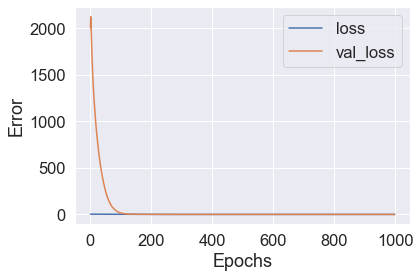

In [90]:
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(X_train.shape[1], input_dim = X_train.shape[1], activation='linear'))
model.add(BatchNormalization())
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer="adam", metrics=['mse', 'mae'])
history = model.fit(X_train, y_train,
                    epochs=1000,
                    verbose=1,
                    validation_data=(X_test, y_test))

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.show()

In [91]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 batch_normalization_3 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 57
Trainable params: 41
Non-trainable params: 16
_________________________________________________________________


In [92]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 16ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0477


[0.00365303922444582, 0.00365303922444582, 0.04770362749695778]

In [93]:
y_preds = model.predict(X_test)

1/1 [==============================] - 0s 55ms/step


In [94]:
print(y_test)

[2.48 1.72 1.86 2.54 2.52 1.8  1.96 2.   1.84 1.82 1.76 2.48 1.96 1.76
 2.48 1.8  1.76 1.84 2.08 2.28 1.76 1.78]


In [95]:
X_test

array([[ 45. , 140. ,   4.5,  80. ],
       [ 43. , 146. ,   9. ,  60. ],
       [ 46. , 141. ,  10. ,  80. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 45. , 140. ,   8. ,  80. ],
       [ 48. , 131. ,  10. , 125. ],
       [ 45. , 141. ,  10. ,  80. ],
       [ 43. , 150. ,   9. ,  50. ],
       [ 46. , 146. ,  10. ,  60. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 45. , 140. ,   8. ,  80. ],
       [ 46. , 146. ,  10. ,  60. ],
       [ 45. , 140. ,   4.5,  80. ],
       [ 47. , 141. ,  12. ,  80. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 48. , 131. ,  10. , 125. ],
       [ 49. , 132. ,   8. , 125. ],
       [ 44. , 146. ,   9. ,  60. ],
       [ 46. , 141. ,  10. ,  80. ]])

In [96]:
print(y_preds)

[[2.4431477]
 [1.7956834]
 [1.8248475]
 [2.5002048]
 [2.5002048]
 [1.8181013]
 [2.0431955]
 [2.0258172]
 [1.8024298]
 [1.7392597]
 [1.7486646]
 [2.5002048]
 [2.0431955]
 [1.7486646]
 [2.4431477]
 [1.6187212]
 [1.8181013]
 [1.8181013]
 [2.0258172]
 [2.264557 ]
 [1.8181013]
 [1.8248475]]


In [97]:
print(" MAE =", mean_absolute_error(y_test, y_preds), "\n", 
    "MSE =", mean_squared_error(y_test, y_preds), "\n", 
     "R_squared =", r2_score(y_test,y_preds))

 MAE = 0.047703633091666496 
 MSE = 0.0036530402921551783 
 R_squared = 0.9572069593627022


In [98]:
res4 = ['Width', 
         'Neural', 
         mean_absolute_error(y_test, y_preds), 
         mean_squared_error(y_test, y_preds), 
         r2_score(y_test, y_preds)]
results_comp.append(res4)

In [99]:
model.save('../models/model_Width.h5')

In [100]:
loaded_width_model= load_model('../models/model_Width.h5')

In [101]:
loaded_width_model.predict(X_test)

1/1 [==============================] - 0s 43ms/step


array([[2.4431477],
       [1.7956834],
       [1.8248475],
       [2.5002048],
       [2.5002048],
       [1.8181013],
       [2.0431955],
       [2.0258172],
       [1.8024298],
       [1.7392597],
       [1.7486646],
       [2.5002048],
       [2.0431955],
       [1.7486646],
       [2.4431477],
       [1.6187212],
       [1.8181013],
       [1.8181013],
       [2.0258172],
       [2.264557 ],
       [1.8181013],
       [1.8248475]], dtype=float32)

## 3.1.3 Решающий лес

In [102]:
tree = DecisionTreeRegressor()

In [103]:
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [104]:
y_pred_tree = tree.predict(X_test)

In [105]:
print(" MAE =", mean_absolute_error(y_test, y_pred_tree), "\n", 
    "MSE =", mean_squared_error(y_test, y_pred_tree), "\n", 
     "R_squared =", r2_score(y_test, y_pred_tree))

 MAE = 0.03639393939393942 
 MSE = 0.001969277777777782 
 R_squared = 0.9769311649390938


In [106]:
res6 = ['Width', 
         'Decision Tree', 
         mean_absolute_error(y_test, y_pred_tree), 
         mean_squared_error(y_test, y_pred_tree), 
         r2_score(y_test, y_pred_tree)]
results_comp.append(res6)

# 3.1.4 Случайный лес

In [107]:
model = RandomForestRegressor(n_estimators = 8, random_state=30)
model.fit(X_train, y_train)
y_pred_RF = model.predict(X_test)

In [108]:
print(" MAE =", mean_absolute_error(y_test, y_pred_RF), "\n", 
    "MSE =", mean_squared_error(y_test, y_pred_RF), "\n", 
     "R_squared =", r2_score(y_test,y_pred_RF))

 MAE = 0.04858658008658006 
 MSE = 0.004062083748482556 
 R_squared = 0.9524152757651716


In [109]:
res8 = ['Width', 
         'Random Forest', 
         mean_absolute_error(y_test, y_pred_RF), 
         mean_squared_error(y_test, y_pred_RF), 
         r2_score(y_test, y_pred_RF)]
results_comp.append(res8)

# 4 Результаты

In [110]:
df_results = pd.DataFrame(results_comp, columns = ['Predictor', 'Method', 'MAE', 'MSE', 'R_squared'])

In [111]:
df_results[df_results.Predictor=='Depth']

,Predictor,Method,MAE,MSE,R_squared
0,Depth,LinearRegression,0.101701,0.017277,0.697671
1,Depth,Neural,0.102058,0.017509,0.693616
2,Depth,Decision Tree,0.066727,0.006861,0.879949
3,Depth,Random Forest,0.070118,0.007540,0.868065


In [112]:
df_results[df_results.Predictor=='Width']

,Predictor,Method,MAE,MSE,R_squared
4,Width,LinearRegression,0.047721,0.003766,0.955878
5,Width,Neural,0.047704,0.003653,0.957207
6,Width,Decision Tree,0.036394,0.001969,0.976931
7,Width,Random Forest,0.048587,0.004062,0.952415
